# **AI Project: Electricity Theft Detection**

Importing required libraries.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, \
    ConfusionMatrixDisplay, precision_recall_fscore_support, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from imblearn.over_sampling import SMOTE

Reading the electricity consumption data for 42372 consumers over 1034 days. Features extracted into the `data` dataframe. Consumer numbers and their flags (labels) extracted into the `infoData` dataframe.

In [2]:
rawData = pd.read_csv('/content/drive/MyDrive/data- Electricity consumption.csv')
infoData = pd.DataFrame()
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)

### Data cleaning and preprocessing - Part 1

1. Dropping duplicate data points.
2. Converting column names in `data` dataframe to datetime format and sorting them chronologically.
3. Filling `NaN` values using linear interpolation.
4. Dropping rows with zero electricity consumption.
5. Reindexing rows in both `data` and `infoData` dataframes.
6. Treating outlier values, by replacing values greater than a threshold with the threshold. Threshold = mean + (3 * S.D.), for each row (data point).

In [3]:
dropIndex = data[data.duplicated()].index  # dropping duplicates
data = data.drop(dropIndex, axis=0)
infoData = infoData.drop(dropIndex, axis=0)

data.columns = pd.to_datetime(data.columns)  # columns reindexing according to dates
data = data.reindex(sorted(data.columns), axis=1)
cols = data.columns

data = data.interpolate(method='linear', limit=2,  # filling NaN values
                        limit_direction='both', axis=0).fillna(0)

zeroIndex = data[(data.sum(axis=1) == 0)].index  # dropping rows with zero sum
data = data.drop(zeroIndex, axis=0)
infoData = infoData.drop(zeroIndex, axis=0)

data.reset_index(inplace=True, drop=True)  # rows reindexing
infoData.reset_index(inplace=True, drop=True)

for i in range(data.shape[0]):  # outliers treatment
    m = data.loc[i].mean()
    sd = data.loc[i].std()
    data.loc[i] = data.loc[i].mask(data.loc[i] > (m + 3 * sd), other=m + 3 * sd)

In [ ]:
scale = MinMaxScaler()
scaled = scale.fit_transform(data.values.T).T
mData = pd.DataFrame(data=scaled, columns=data.columns)
preprData = pd.concat([infoData, mData], axis=1, sort=False)  # Back to initial format
preprData.to_csv(r'preprocessedR.csv', index=False, header=True)

In [ ]:
test_set_size = 0.2  # percentage of the test size comparing to the whole dataset
oversampling_flag = 1  # set to 1 to over-sample the minority class
oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class

In [ ]:
def read_data():
    rawData = pd.read_csv('preprocessedR.csv')

    y = rawData[['FLAG']]
    X = rawData.drop(['FLAG', 'CONS_NO'], axis=1)

    print('Normal Consumers:                       ', y[y['FLAG'] == 0].count()[0])
    print('Consumers with Fraud:                   ', y[y['FLAG'] == 1].count()[0])
    print('Total Consumers:                        ', y.shape[0])
    print("Percentage of normal consumers:          %.2f" % (y[y['FLAG'] == 0].count()[0] / y.shape[0] * 100), "%\n")

    # columns reindexing according to dates
    X.columns = pd.to_datetime(X.columns)
    X = X.reindex(X.columns, axis=1)

    # Splitting the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y['FLAG'], test_size=test_set_size, random_state=0)
    print("Percentage of normal consumers in Test set: %.2f" % (y_test[y_test == 0].count() / y_test.shape[0] * 100), "%\n")

    # Oversampling of minority class to encounter the imbalanced learning
    if oversampling_flag == 1:
        over = SMOTE(sampling_strategy=oversampling_percentage, random_state=0)
        X_train, y_train = over.fit_resample(X_train, y_train)
        print("Oversampling statistics in training set: ")
        print('Normal Consumers:          ', y_train[y_train == 0].count())
        print('Consumers with Fraud:      ', y_train[y_train == 1].count())
        print("Total Consumers            ", X_train.shape[0])

    return X_train, X_test, y_train, y_test

In [ ]:
def results(y_test, prediction):
    accuracy = 100 * accuracy_score(y_test, prediction)
    auc = 100 * roc_auc_score(y_test, prediction)
    f1_score_0 = 100 * precision_recall_fscore_support(y_test, prediction)[2][0]
    f1_score_1 = 100 * precision_recall_fscore_support(y_test, prediction)[2][1]
    print("Accuracy", accuracy)
    print("F1:", [f1_score_0, f1_score_1])
    print("AUC:", auc)
    cm = confusion_matrix(y_test, prediction)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    return auc, accuracy, f1_score_0, f1_score_1

In [ ]:
X_train, X_test, y_train, y_test = read_data()

Normal Consumers:                        37887
Consumers with Fraud:                    3601
Total Consumers:                         41488
Percentage of normal consumers:          91.32 %

Percentage of normal consumers in Test set: 90.97 %

Oversampling statistics in training set: 
Normal Consumers:           30338
Consumers with Fraud:       6067
Total Consumers             36405


In [ ]:
def NN1(X_train, X_test, y_train, y_test):
    print('Neural Network 1:')

    # Model creation
    model = Sequential()
    model.add(Dense(1034, input_dim=1034, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    performance_results = []

    for i in range(1, 22, 3):
        print("Epoch:", i)
        model.fit(X_train, y_train, validation_split=0, epochs=i, shuffle=True, verbose=0)
        prediction = (model.predict(X_test)>0.5).astype("int32")
        auc, accuracy, f1_score_0, f1_score_1 = results(y_test, prediction)
        performance_results.append({'Epochs': i, 'AUC': auc, 'Accuracy': accuracy, 'F1 (0)': f1_score_0, 'F1 (1)': f1_score_1})

    nn_results_df = pd.DataFrame(performance_results)
    nn_results_df.to_csv('NN1 epochs results.csv', index=False)


Neural Network 1:
Epoch: 1
260/260 [==============================] - 2s 8ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 90.97372860930345
F1: [95.27355335394712, 0.0]
AUC: 50.0


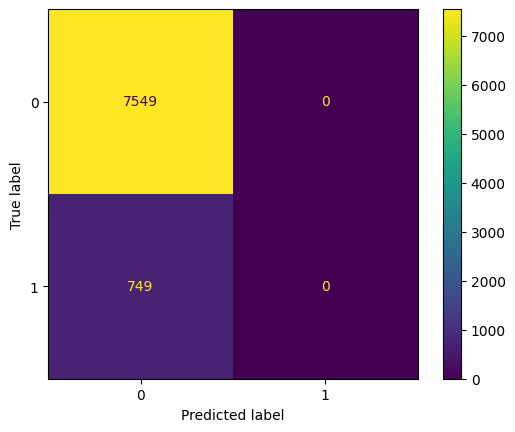

Epoch: 4
260/260 [==============================] - 1s 4ms/step
Accuracy 84.73126054470956
F1: [91.2986745415837, 37.739557739557746]
AUC: 69.65987767325569


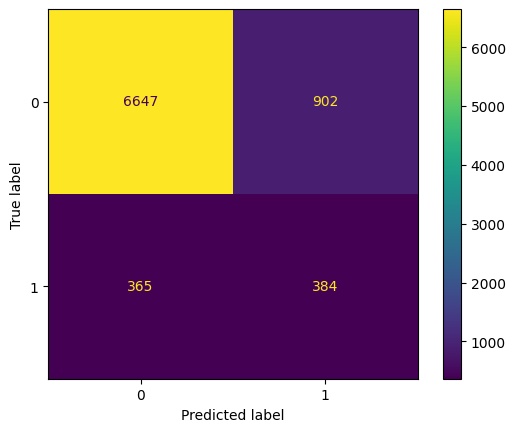

Epoch: 7
260/260 [==============================] - 1s 4ms/step
Accuracy 91.56423234514341
F1: [95.49723401518074, 33.33333333333333]
AUC: 60.84769536845259


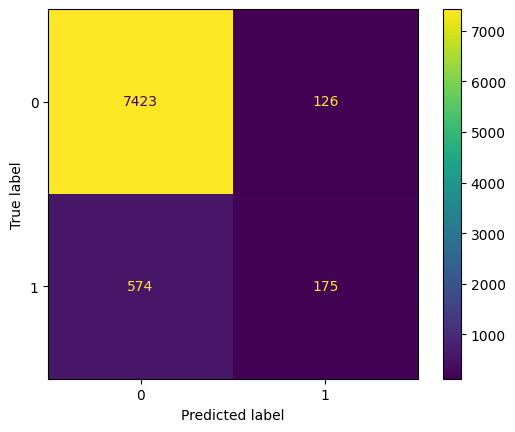

Epoch: 10
260/260 [==============================] - 1s 4ms/step
Accuracy 91.8534586647385
F1: [95.6493757240314, 36.10586011342155]
AUC: 61.96877330678552


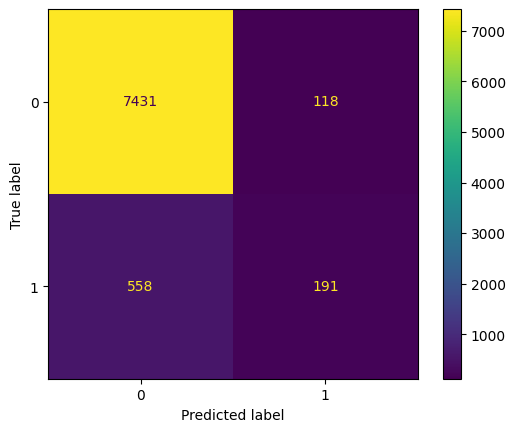

Epoch: 13
260/260 [==============================] - 1s 4ms/step
Accuracy 91.39551699204628
F1: [95.36604361370716, 39.8989898989899]
AUC: 64.48316924000402


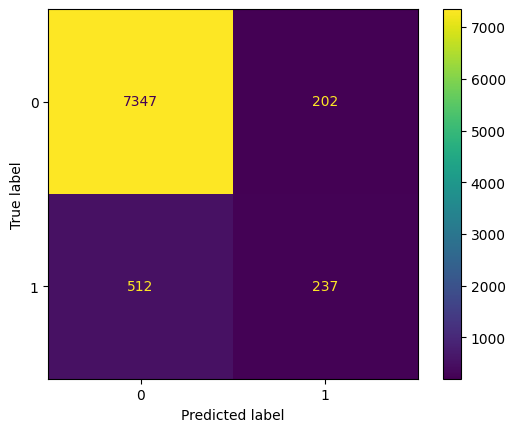

Epoch: 16
260/260 [==============================] - 2s 8ms/step
Accuracy 90.41937816341287
F1: [94.76319083064357, 43.81625441696113]
AUC: 68.33633080960512


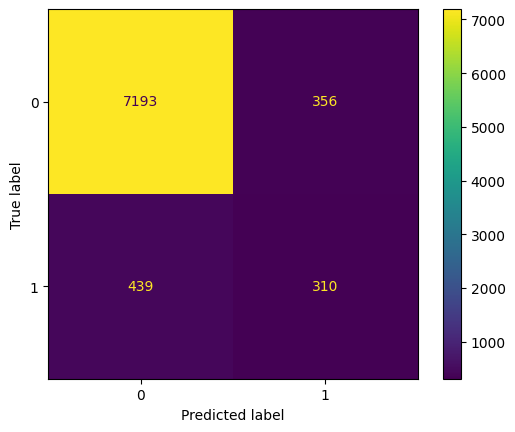

Epoch: 19
260/260 [==============================] - 1s 4ms/step
Accuracy 91.05808628585201
F1: [95.13761467889908, 44.461077844311376]
AUC: 67.90565103716688


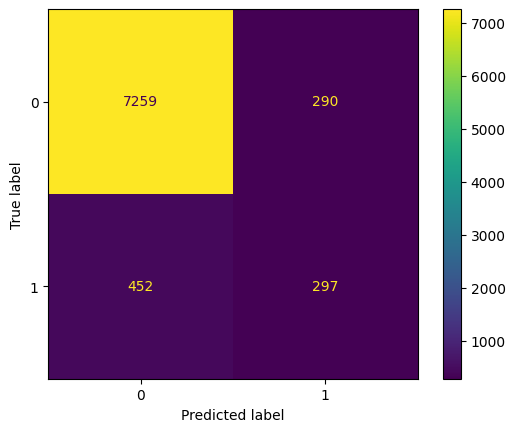

In [ ]:
NN1(X_train, X_test, y_train, y_test)

Text(0.5, 0, 'Number of Epochs')

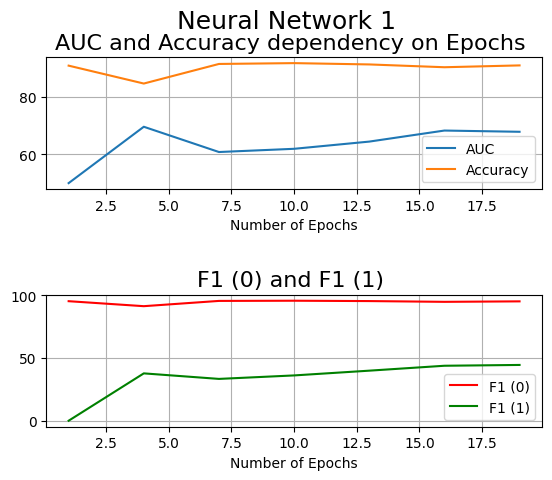

In [ ]:
nn = pd.read_csv('NN1 epochs results.csv')
nn = nn.set_index('Epochs')

# print(nn)

fig, axs = plt.subplots(2, 1)
fig.suptitle('Neural Network 1', fontsize=18)
plt.subplots_adjust(hspace=0.8)
nn[['AUC', 'Accuracy']].plot(ax=axs[0], grid=True)
axs[0].set_title('AUC and Accuracy dependency on Epochs ', fontsize=16)
axs[0].set_xlabel('Number of Epochs')

nn[['F1 (0)', 'F1 (1)']].plot(ax=axs[1], grid=True,color=['red','green'])
axs[1].set_title('F1 (0) and F1 (1) ', fontsize=16)
axs[1].set_xlabel('Number of Epochs')

In [ ]:
def NN2(X_train, X_test, y_train, y_test):
    print('Neural Network 2:')

    # Model creation
    model = Sequential()
    model.add(Dense(1034, input_dim=1034, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(125, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=[keras.metrics.BinaryAccuracy()])

    performance_results = []

    for i in range(1, 22, 3):
        print("Epoch:", i)
        model.fit(X_train, y_train, validation_split=0, epochs=i, shuffle=True, verbose=0)
        prediction = (model.predict(X_test)>=0.3).astype("int32")
        auc, accuracy, f1_score_0, f1_score_1 = results(y_test, prediction)
        performance_results.append({'Epochs': i, 'AUC': auc, 'Accuracy': accuracy, 'F1 (0)': f1_score_0, 'F1 (1)': f1_score_1})

    nn_results_df = pd.DataFrame(performance_results)
    nn_results_df.to_csv('NN2 epochs results.csv', index=False)

Neural Network 2:
Epoch: 1
260/260 [==============================] - 2s 9ms/step
Accuracy 87.55121716076162
F1: [93.25850029367618, 18.853102906520032]
AUC: 55.33482980177039


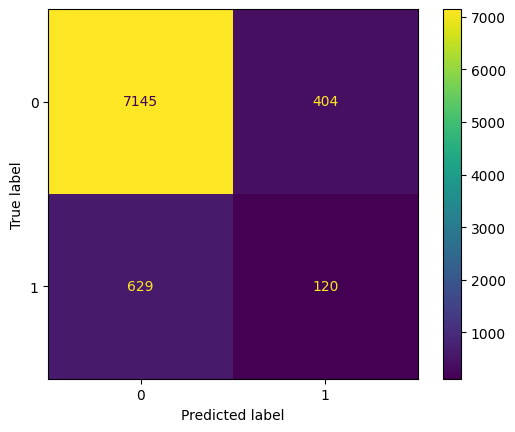

Epoch: 4
260/260 [==============================] - 2s 8ms/step
Accuracy 82.646420824295
F1: [89.94694219491764, 36.61971830985916]
AUC: 70.43826351415522


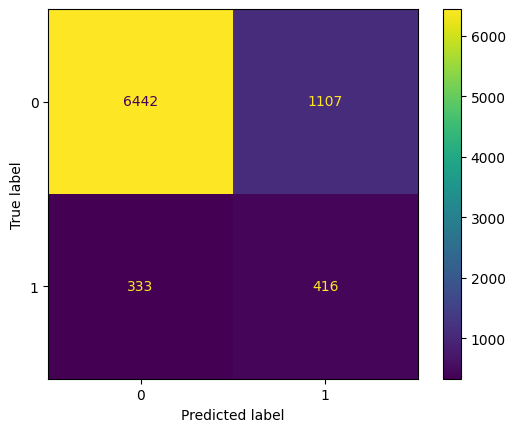

Epoch: 7
260/260 [==============================] - 1s 5ms/step
Accuracy 89.63605688117619
F1: [94.30086149768057, 42.89508632138114]
AUC: 68.68752985611937


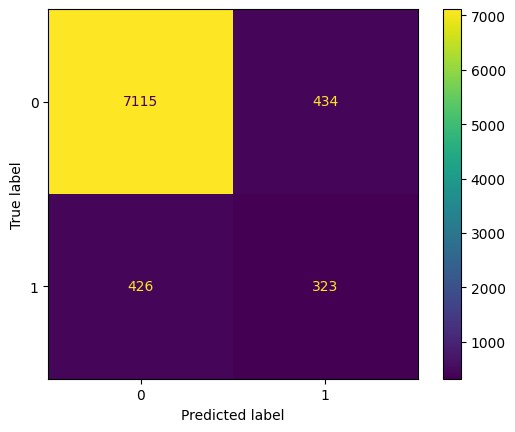

Epoch: 10
260/260 [==============================] - 1s 5ms/step
Accuracy 88.05736322005302
F1: [93.35657303747404, 40.97677188802859]
AUC: 69.08264315329433


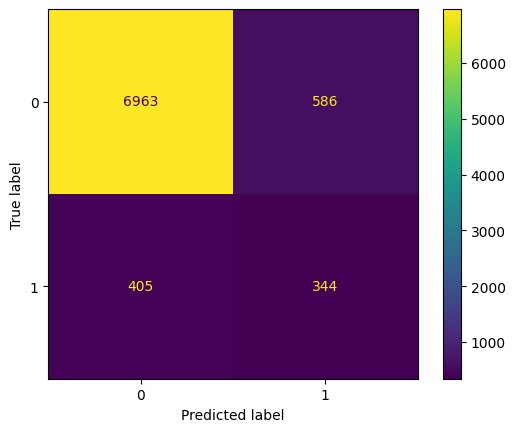

Epoch: 13
260/260 [==============================] - 1s 5ms/step
Accuracy 89.25042178838274
F1: [94.08095554080955, 41.54652686762779]
AUC: 68.11478757122359


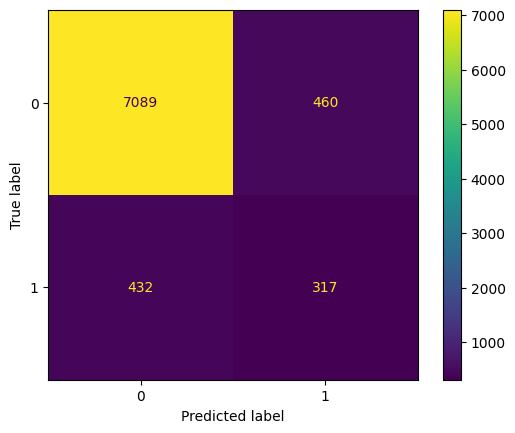

Epoch: 16
260/260 [==============================] - 1s 5ms/step
Accuracy 88.92504217883828
F1: [93.8565412126479, 43.860720830788026]
AUC: 70.4615117149178


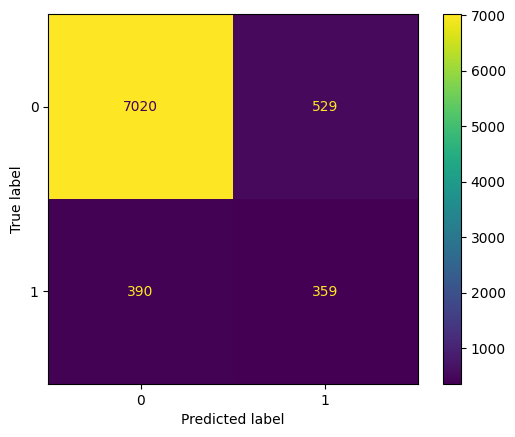

Epoch: 19
260/260 [==============================] - 2s 6ms/step
Accuracy 89.70836346107495
F1: [94.37343523520885, 39.77433004231312]
AUC: 66.26184672246353


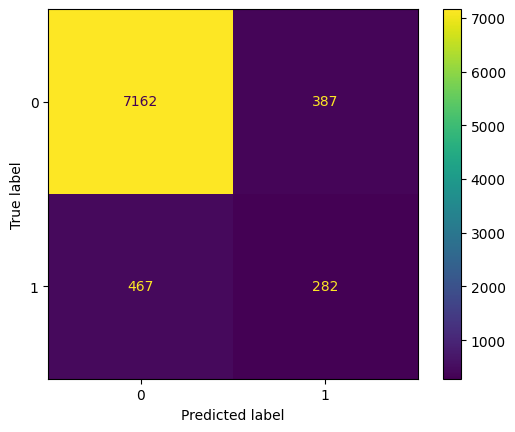

In [ ]:
NN2(X_train, X_test, y_train, y_test)

Text(0.5, 0, 'Number of Epochs')

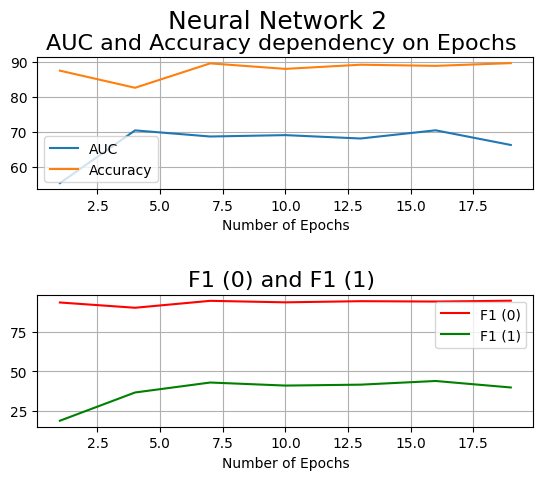

In [ ]:
nn = pd.read_csv('NN2 epochs results.csv')
nn = nn.set_index('Epochs')

# print(nn)

fig, axs = plt.subplots(2, 1)
fig.suptitle('Neural Network 2', fontsize=18)
plt.subplots_adjust(hspace=0.8)
nn[['AUC', 'Accuracy']].plot(ax=axs[0], grid=True)
axs[0].set_title('AUC and Accuracy dependency on Epochs ', fontsize=16)
axs[0].set_xlabel('Number of Epochs')

nn[['F1 (0)', 'F1 (1)']].plot(ax=axs[1], grid=True,color=['red','green'])
axs[1].set_title('F1 (0) and F1 (1) ', fontsize=16)
axs[1].set_xlabel('Number of Epochs')